In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


In [29]:
for c in ["D","R","Vobs","e_Vobs","Vgas","Vdisk","Vbul","SBdisk","SBbul"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")


In [31]:
import os
print("Working directory:", os.getcwd())


Working directory: C:\Users\Marco\Desktop\seag-rotation-curves


In [32]:
fname = "data/RC_MRT.txt"


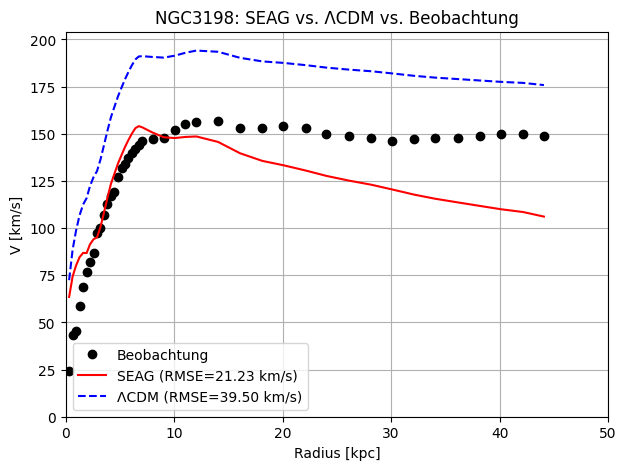

{'Galaxy': 'NGC3198', 'RMSE_SEAG': np.float64(21.231962358800185), 'RMSE_LCDM': np.float64(39.499372464244836)}


In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from astropy import constants as const

# Gravitationelle Konstante in kpc·(M_sun)^−1·(km/s)^2
G = 4.30091e-6

# SEAG‐Funktionen (wie gehabt)
def alpha_seag(r_kpc, z, rho_cgs, beta_G=1.5, mu0_cm=(70*1e5)/(3.086e24)/const.c.to('cm/s').value):
    mu_cm = 1/(r_kpc*3.086e21)
    return (beta_G/(4*np.pi**2))*np.log(mu_cm/mu0_cm) \
           + 0.15*(1+z)**(-0.6) \
           + 0.05*(rho_cgs/1e-24)**0.3

def v_recall(r, Mb, r0, rc, alpha):
    v0 = 47.0*(Mb/1e9)**0.25
    return alpha * v0 * np.log(1 + r/r0) * np.exp(-r/rc)

def v_seag(r, vbar, Mb, r0, rc, z, rho_c):
    α = alpha_seag(r, z, rho_c)
    return np.sqrt(vbar**2 + v_recall(r, Mb, r0, rc, α)**2)

# NFW‐Halo
def v_nfw(r, rho_s, r_s):
    x = r/r_s
    m_enc = 4*np.pi*rho_s*r_s**3*(np.log(1+x) - x/(1+x))
    return np.sqrt(G*m_enc/r)

def fit_nfw(r, vobs):
    def χ2(p):
        ρs, rs = p
        if ρs<=0 or rs<=0: return 1e9
        return np.sum((vobs - v_nfw(r, ρs, rs))**2)
    res = minimize(χ2, x0=[1e7,10], bounds=((1e5,1e10),(0.1,100)), 
                   options={'maxiter':2000})
    return res.x

# RMSE‐Hilfsfunktion
def rmse(a,b):
    return np.sqrt(np.mean((a-b)**2))

def process_galaxy(df, name, z=0.0, rc=50.0):
    sub = df[df['ID']==name].sort_values('R').dropna(subset=['Vgas','Vdisk','Vbul'])
    if sub.empty:
        raise ValueError(f"Keine Daten für Galaxie {name} gefunden!")

    # in NumPy-Arrays umwandeln
    r     = sub['R'].to_numpy()
    vobs  = sub['Vobs'].to_numpy()
    vbar  = np.sqrt(sub['Vgas'].to_numpy()**2
                   + sub['Vdisk'].to_numpy()**2
                   + sub['Vbul'].to_numpy()**2)

    # Gesamtbaryonische Masse aus letztem Punkt
    Mb    = (vbar[-1]**2 * r[-1]) / G

    # mittlere Dichte
    rho_c = Mb/(np.pi * r[-1]**2 * 0.3) * 1.989e33/(3.086e21)**3

    # Skalenradius r0 = Radius bei maximaler baryonischer Geschwindigkeit
    r0    = r[np.argmax(vbar)]

    # Modelle
    vse   = v_seag(r, vbar, Mb, r0, rc, z, rho_c)
    rho_s, r_s = fit_nfw(r, vobs)
    vlcdm = np.sqrt(vbar**2 + v_nfw(r, rho_s, r_s)**2)

    # RMSE
    err_seag = rmse(vse, vobs)
    err_lcdm = rmse(vlcdm, vobs)

    # Plot
    plt.figure(figsize=(7,5))
    plt.plot(r, vobs,  'ko', label='Beobachtung')
    plt.plot(r, vse,   'r-',  label=f'SEAG (RMSE={err_seag:.2f} km/s)')
    plt.plot(r, vlcdm,'b--', label=f'ΛCDM (RMSE={err_lcdm:.2f} km/s)')
    plt.xlabel('Radius [kpc]')
    plt.ylabel('V [km/s]')
    plt.xlim(0,50)
    plt.ylim(0, max(vobs)*1.3)
    plt.title(f'{name}: SEAG vs. ΛCDM vs. Beobachtung')
    plt.grid(True)
    plt.legend()
    plt.show()

    return {'Galaxy':name, 'RMSE_SEAG':err_seag, 'RMSE_LCDM':err_lcdm}
# Beispiel für NGC3198
# df muss Deine eingelesene SPARC-Tabelle sein, z.B. df = pd.read_fwf(...)
results = process_galaxy(df, 'NGC3198')
print(results)